In [23]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
from math import sqrt

import sys


sys.path.append('../..')
# sys.path.append('../')

import optimneuralts
import viz_config
from utils import *

torch.set_default_tensor_type("torch.FloatTensor")

saves_path = '../saves'
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
def compute_n_inter(tens1:torch.Tensor, tens2:torch.Tensor):
    set1 = tens1.unique(dim=0).tolist()
    set2 = tens2.unique(dim=0).tolist()
    
    set1 = set([tuple(item) for item in set1])
    set2 = set([tuple(item) for item in set2])

    inter = set1 & set2
    n_inter = len(set1 & set2)
    percent_of_set1_in_set2 = np.float32(n_inter) / np.float32(len(set1))

    return n_inter, percent_of_set1_in_set2

In [69]:
# Skew 0 vs regular
experiments = [
    "DE_500_rx_100000_combis_10_patterns_23_bs64_warmup20000_nmembers32_valnoval_ldsFalse_trainevery10_patience100_usedecay_lrplateau_layers1_withnoise_exactdecay_expl1",
    "DE_500_rx_100000_combis_10_patterns_skew0_35_bs64_warmup20000_nmembers32_valnoval_ldsFalse_trainevery10_patience100_usedecay_lrplateau_layers1_withnoise_exactdecay_expl1",
]
labels = ["Distribution centrée vers 1", "Distribution centrée près de 0"]
labels_fn = "DE_SKEW0_VS_NORMAL"

datasets = [
    "500_rx_100000_combis_10_patterns_23",
    "500_rx_100000_combis_10_patterns_skew0_35",
]

# Gamma = 1, 10, DE vs Adam
# experiments = [
#     "DE_500_rx_100000_combis_10_patterns_23_bs64_warmup10000_nmembers32_valnoval_ldsFalse_trainevery10_patience100_usedecay_lrplateau_layers1_withnoise_exactdecay_expl1",
#     "DE_500_rx_100000_combis_10_patterns_23_bs64_warmup10000_nmembers32_valnoval_ldsFalse_trainevery10_patience100_usedecay_lrplateau_layers1_withnoise_exactdecay_expl10",
#     "500_rx_100000_combis_10_patterns_23_bs64_warmup10000_nmembers512_valnoval_ldsFalse_trainevery10_patience100_usedecay_lrplateau_layers1_withnoise_exactdecay_expl1",
#     "500_rx_100000_combis_10_patterns_23_bs64_warmup10000_nmembers512_valnoval_ldsFalse_trainevery10_patience100_usedecay_lrplateau_layers1_withnoise_exactdecay_expl10",
# ]
# labels = [
#     "ÉD, $\\nu = 1$",
#     "ÉD, $\\nu = 10$",
#     "Adam, $\\nu = 1$",
#     "Adam, $\\nu = 10$",
# ]
# labels_fn = "DE_VS_ADAM"

# datasets = [
#     "500_rx_100000_combis_10_patterns_23",
#     "500_rx_100000_combis_10_patterns_23",
#     "500_rx_100000_combis_10_patterns_23",
#     "500_rx_100000_combis_10_patterns_23",
# ]

prefix = "memoire_near_0_20k_warmup"
n_trials = 10000
n_runs = 25
metrics_dict = {}
metrics = [
    "jaccards",
    "jaccards_alls",
    "ratio_apps_alls",
    "ratio_apps",
    "ratio_found_pats",
    "ratio_found_pats_alls",
    "losses",
    "dataset_losses",
    "n_inter_alls",
    "all_flagged_risks",
    "agents",
    "all_flagged_combis_idx",
]


for exp in experiments:
    metrics_dict[exp] = {}
    for metric in metrics:
        metrics_dict[exp][metric] = []
        for run in range(n_runs):
            path = f"{saves_path}/{exp}/{metric}/{run}.pth"
            metrics_dict[exp][metric].append(torch.load(path))


In [70]:
colors = ["tab:orange", "tab:purple", "tab:green", "tab:red", "tab:cyan", "tab:brown"]
interval = 200
upper_lim = 30100


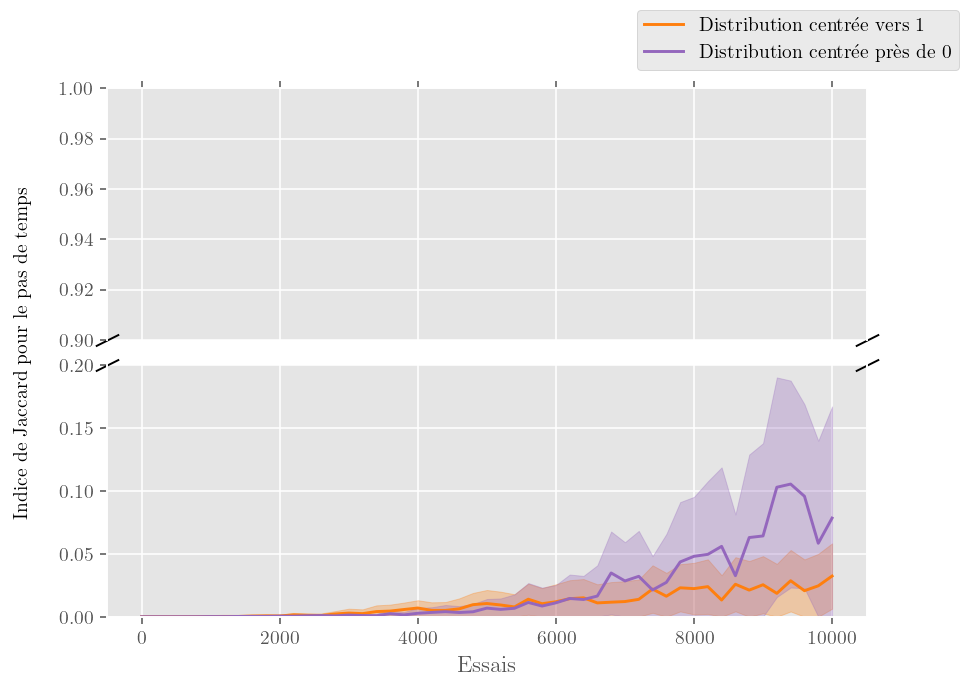

In [74]:
metric = "jaccards"
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
fig.subplots_adjust(hspace=0.1)  # adjust space between axes
# zoom-in / limit the view to different portions of the data
ax1.set_ylim(0.9, 1.0)  # outliers only
ax2.set_ylim(0, 0.2)  # most of the data
# hide the spines between ax and ax2
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

for i, exp in enumerate(metrics_dict.keys()):
    means = np.nanmean(metrics_dict[exp][metric], axis=0)[: (upper_lim // interval)]
    stds = np.nanstd(metrics_dict[exp][metric], axis=0)[: (upper_lim // interval)]
    x = np.arange(len(means)) * interval

    # ax1.plot(x, means, color=colors[i], label=labels[i])
    # ax1.fill_between(
    #     x,
    #     np.clip(means - stds, 0, 1),
    #     np.clip(means + stds, 0, 1),
    #     color=colors[i],
    #     alpha=0.3,
    # )
    ax2.plot(x, means, color=colors[i], label=labels[i])
    ax2.fill_between(
        x,
        np.clip(means - stds, 0, 1),
        np.clip(means + stds, 0, 1),
        color=colors[i],
        alpha=0.3,
    )

d = 0.5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(
    marker=[(-1, -d), (1, d)],
    markersize=12,
    linestyle="none",
    color="k",
    mec="k",
    mew=1,
    clip_on=False,
)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

ax2.set_xlabel("Essais")
# ax2.set_ylabel("Indice de Jaccard pour le pas de temps")
# ax1.set_ylim(0, 1.05)
fig.text(0.03, 0.5, 'Rappel pour le pas de temps', va='center', rotation='vertical')
fig.legend()

# fig.tight_layout()


fig.savefig(f"images/polypharmacy/perf/{prefix}_{metric}_{labels_fn}")


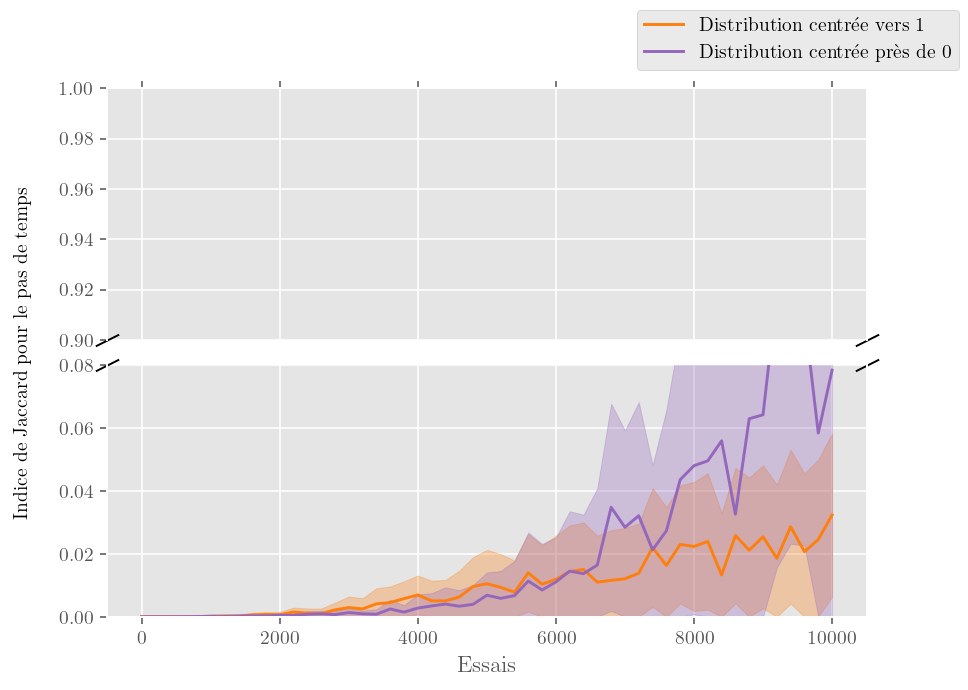

In [77]:
metric = "jaccards"
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
fig.subplots_adjust(hspace=0.1)  # adjust space between axes
# zoom-in / limit the view to different portions of the data
ax1.set_ylim(0.9, 1.0)  # outliers only
ax2.set_ylim(0, 0.08)  # most of the data
# hide the spines between ax and ax2
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

for i, exp in enumerate(metrics_dict.keys()):
    means = np.nanmean(metrics_dict[exp][metric], axis=0)[: (upper_lim // interval)]
    stds = np.nanstd(metrics_dict[exp][metric], axis=0)[: (upper_lim // interval)]
    x = np.arange(len(means)) * interval

    # ax1.plot(x, means, color=colors[i], label=labels[i])
    # ax1.fill_between(
    #     x,
    #     np.clip(means - stds, 0, 1),
    #     np.clip(means + stds, 0, 1),
    #     color=colors[i],
    #     alpha=0.3,
    # )
    ax2.plot(x, means, color=colors[i], label=labels[i])
    ax2.fill_between(
        x,
        np.clip(means - stds, 0, 1),
        np.clip(means + stds, 0, 1),
        color=colors[i],
        alpha=0.3,
    )

d = 0.5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(
    marker=[(-1, -d), (1, d)],
    markersize=12,
    linestyle="none",
    color="k",
    mec="k",
    mew=1,
    clip_on=False,
)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

ax2.set_xlabel("Essais")
# ax2.set_ylabel("Indice de Jaccard pour le pas de temps")
# ax1.set_ylim(0, 1.05)
fig.text(0.03, 0.5, 'Rappel pour le pas de temps', va='center', rotation='vertical')
fig.legend()

# fig.tight_layout()


fig.savefig(f"images/polypharmacy/perf/{prefix}_{metric}_{labels_fn}_zoomed")


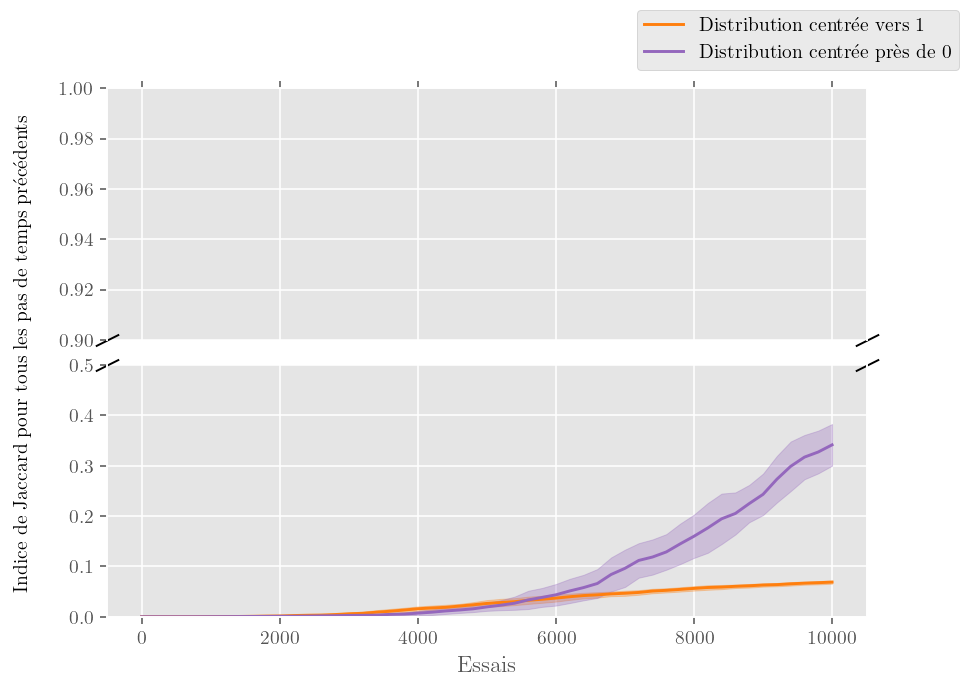

In [79]:
metric = "jaccards_alls"
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
fig.subplots_adjust(hspace=0.1)  # adjust space between axes
# zoom-in / limit the view to different portions of the data
ax1.set_ylim(0.9, 1.0)  # outliers only
ax2.set_ylim(0, 0.5)  # most of the data
# hide the spines between ax and ax2
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

for i, exp in enumerate(metrics_dict.keys()):
    means = np.nanmean(metrics_dict[exp][metric], axis=0)[: (upper_lim // interval)]
    stds = np.nanstd(metrics_dict[exp][metric], axis=0)[: (upper_lim // interval)]
    x = np.arange(len(means)) * interval

    # ax1.plot(x, means, color=colors[i], label=labels[i])
    # ax1.fill_between(
    #     x,
    #     np.clip(means - stds, 0, 1),
    #     np.clip(means + stds, 0, 1),
    #     color=colors[i],
    #     alpha=0.3,
    # )
    ax2.plot(x, means, color=colors[i], label=labels[i])
    ax2.fill_between(
        x,
        np.clip(means - stds, 0, 1),
        np.clip(means + stds, 0, 1),
        color=colors[i],
        alpha=0.3,
    )

d = 0.5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(
    marker=[(-1, -d), (1, d)],
    markersize=12,
    linestyle="none",
    color="k",
    mec="k",
    mew=1,
    clip_on=False,
)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

ax2.set_xlabel("Essais")
# ax2.set_ylabel("Indice de Jaccard pour le pas de temps")
# ax1.set_ylim(0, 1.05)
fig.text(0.03, 0.5, 'Rappel pour tous les pas de temps précédents', va='center', rotation='vertical')
fig.legend()


# fig.tight_layout()


fig.savefig(f"images/polypharmacy/perf/{prefix}_{metric}_{labels_fn}")



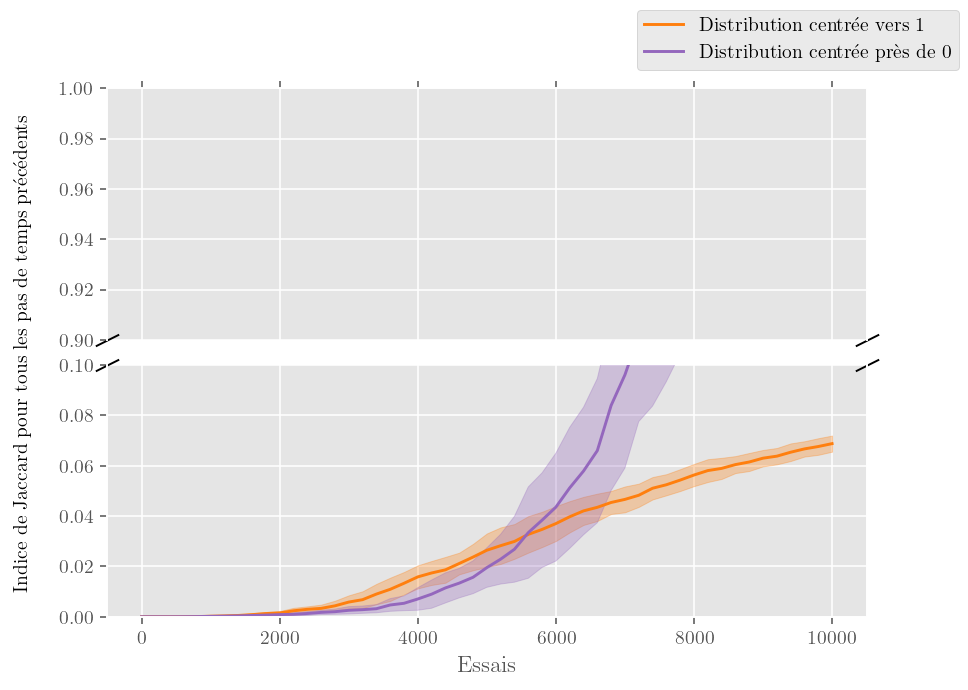

In [80]:
metric = "jaccards_alls"
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
fig.subplots_adjust(hspace=0.1)  # adjust space between axes
# zoom-in / limit the view to different portions of the data
ax1.set_ylim(0.9, 1.0)  # outliers only
ax2.set_ylim(0, 0.1)  # most of the data
# hide the spines between ax and ax2
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

for i, exp in enumerate(metrics_dict.keys()):
    means = np.nanmean(metrics_dict[exp][metric], axis=0)[: (upper_lim // interval)]
    stds = np.nanstd(metrics_dict[exp][metric], axis=0)[: (upper_lim // interval)]
    x = np.arange(len(means)) * interval

    # ax1.plot(x, means, color=colors[i], label=labels[i])
    # ax1.fill_between(
    #     x,
    #     np.clip(means - stds, 0, 1),
    #     np.clip(means + stds, 0, 1),
    #     color=colors[i],
    #     alpha=0.3,
    # )
    ax2.plot(x, means, color=colors[i], label=labels[i])
    ax2.fill_between(
        x,
        np.clip(means - stds, 0, 1),
        np.clip(means + stds, 0, 1),
        color=colors[i],
        alpha=0.3,
    )

d = 0.5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(
    marker=[(-1, -d), (1, d)],
    markersize=12,
    linestyle="none",
    color="k",
    mec="k",
    mew=1,
    clip_on=False,
)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

ax2.set_xlabel("Essais")
# ax2.set_ylabel("Indice de Jaccard pour le pas de temps")
# ax1.set_ylim(0, 1.05)
fig.text(0.03, 0.5, 'Rappel pour tous les pas de temps précédents', va='center', rotation='vertical')
fig.legend()


# fig.tight_layout()


fig.savefig(f"images/polypharmacy/perf/{prefix}_{metric}_{labels_fn}_zoomed")



/tmp/ipykernel_485391/3186510235.py:4: RuntimeWarning: Mean of empty slice
  means = np.nanmean(metrics_dict[exp][metric], axis=0)[: (upper_lim // interval)]
/home/quoding/Documents/Maitrise/venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_485391/3186510235.py:4: RuntimeWarning: Mean of empty slice
  means = np.nanmean(metrics_dict[exp][metric], axis=0)[: (upper_lim // interval)]
/home/quoding/Documents/Maitrise/venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


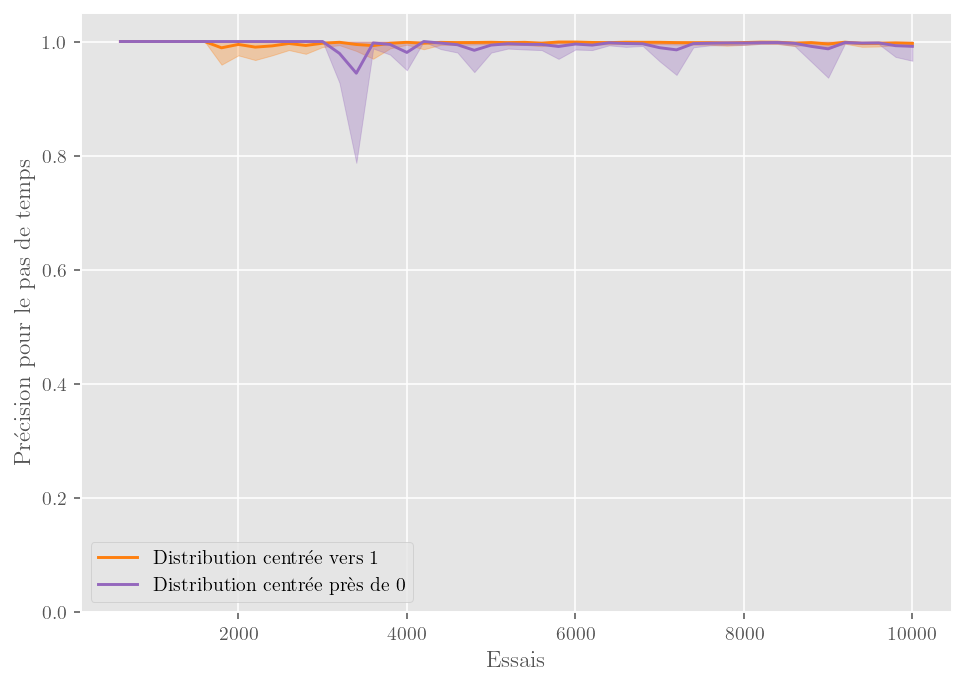

In [81]:
metric = "ratio_apps"

for i, exp in enumerate(metrics_dict.keys()):
    means = np.nanmean(metrics_dict[exp][metric], axis=0)[: (upper_lim // interval)]
    stds = np.nanstd(metrics_dict[exp][metric], axis=0)[: (upper_lim // interval)]
    x = np.arange(len(means)) * interval

    plt.plot(x, means, color=colors[i], label=labels[i])
    plt.fill_between(
        x,
        np.clip(means - stds, 0, 1),
        np.clip(means + stds, 0, 1),
        color=colors[i],
        alpha=0.3,
    )
    plt.xlabel("Essais")
    plt.ylabel("Précision pour le pas de temps")
plt.legend()
plt.ylim(0, 1.05)
plt.tight_layout()
# plt.show()
plt.savefig(f'images/polypharmacy/perf/{prefix}_{metric}_{labels_fn}')


/tmp/ipykernel_485391/3575452256.py:4: RuntimeWarning: Mean of empty slice
  means = np.nanmean(metrics_dict[exp][metric], axis=0)[: (upper_lim // interval)]
/home/quoding/Documents/Maitrise/venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_485391/3575452256.py:4: RuntimeWarning: Mean of empty slice
  means = np.nanmean(metrics_dict[exp][metric], axis=0)[: (upper_lim // interval)]
/home/quoding/Documents/Maitrise/venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


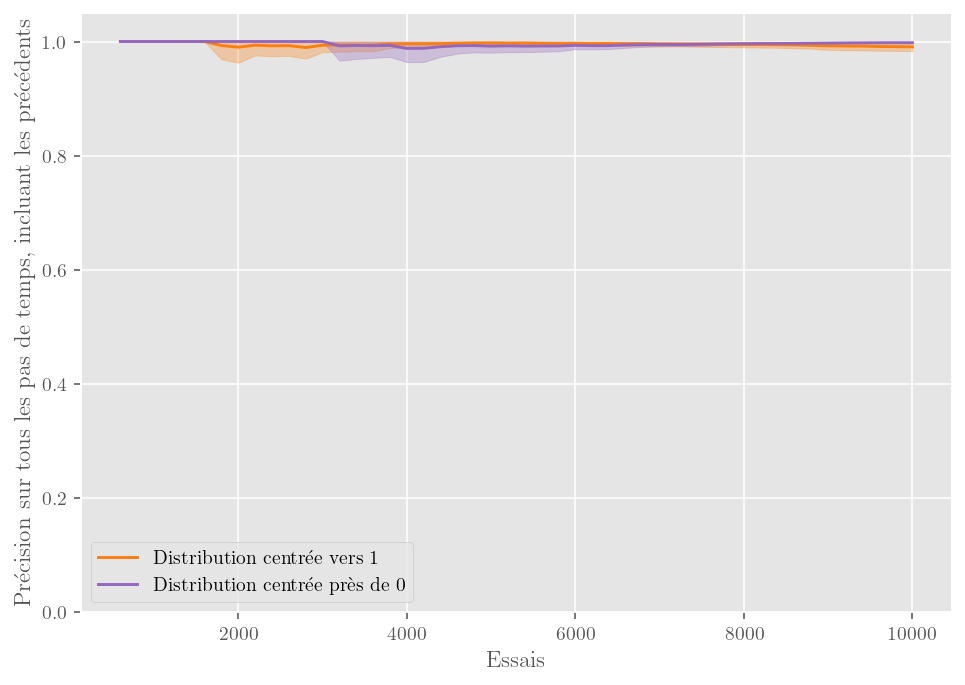

In [82]:
metric = "ratio_apps_alls"

for i, exp in enumerate(metrics_dict.keys()):
    means = np.nanmean(metrics_dict[exp][metric], axis=0)[: (upper_lim // interval)]
    stds = np.nanstd(metrics_dict[exp][metric], axis=0)[: (upper_lim // interval)]
    x = np.arange(len(means)) * interval

    plt.plot(x, means, color=colors[i], label=labels[i])
    plt.fill_between(
        x,
        np.clip(means - stds, 0, 1),
        np.clip(means + stds, 0, 1),
        color=colors[i],
        alpha=0.3,
    )
    plt.xlabel("Essais")
    plt.ylabel("Précision sur tous les pas de temps, incluant les précédents")
plt.legend()
plt.ylim(0, 1.05)
plt.tight_layout()
# plt.show()
plt.savefig(f'images/polypharmacy/perf/{prefix}_{metric}_{labels_fn}')


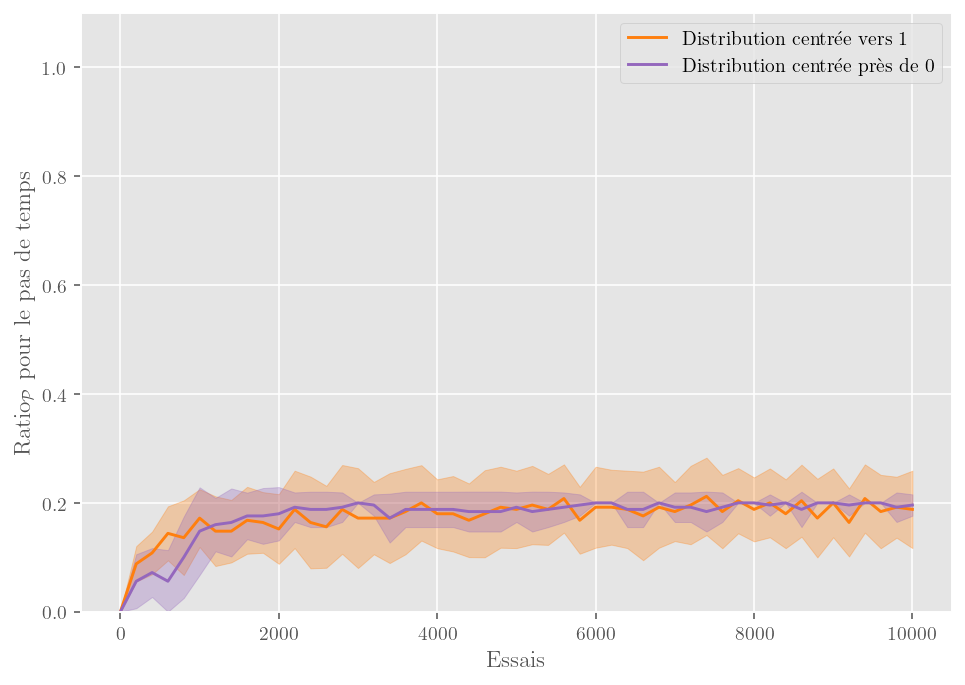

In [83]:
# Plot ratio found pat
metric = "ratio_found_pats"

for i, exp in enumerate(metrics_dict.keys()):
    means = np.nanmean(metrics_dict[exp][metric], axis=0)[:(upper_lim // interval)]
    stds = np.nanstd(metrics_dict[exp][metric], axis=0)[:(upper_lim// interval)]
    x = np.arange(len(means)) * interval


    plt.plot(x, means, color=colors[i], label=labels[i])
    plt.fill_between(x, np.clip(means - stds, 0, 1), np.clip(means + stds, 0, 1), color=colors[i], alpha=0.3)
plt.xlabel('Essais')
plt.ylabel("Ratio$_{\mathcal{P}}$ pour le pas de temps")
plt.legend()
plt.ylim(0, 1.1)
plt.tight_layout()

plt.savefig(f'images/polypharmacy/perf/{prefix}_{metric}_{labels_fn}')



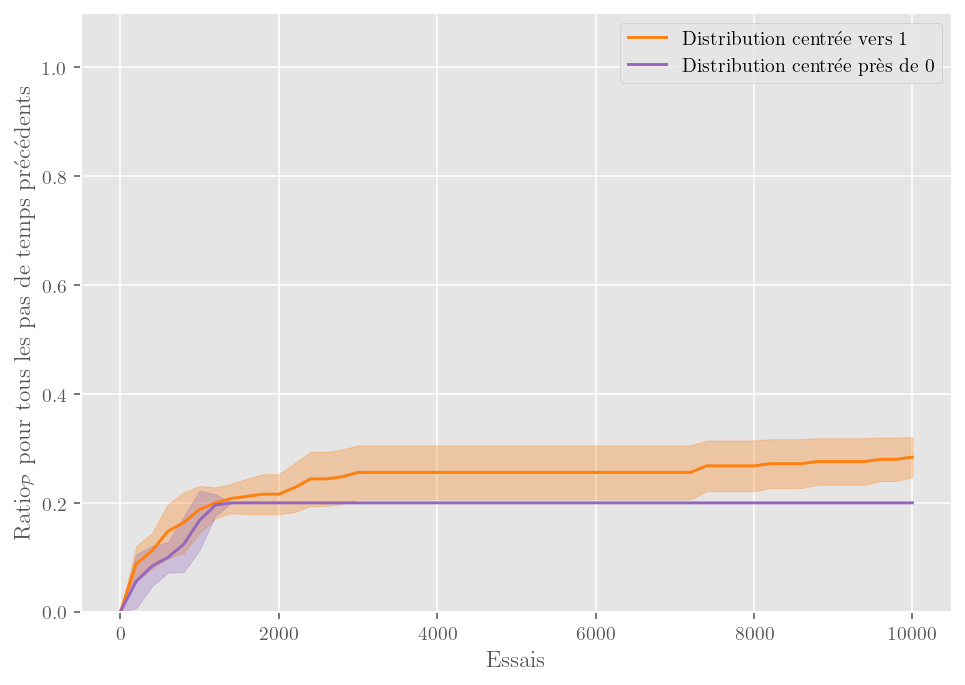

In [84]:
# Plot ratio found pat
metric = "ratio_found_pats_alls"

for i, exp in enumerate(metrics_dict.keys()):
    means = np.nanmean(metrics_dict[exp][metric], axis=0)[:(upper_lim // interval)]
    stds = np.nanstd(metrics_dict[exp][metric], axis=0)[:(upper_lim// interval)]
    x = np.arange(len(means)) * interval


    plt.plot(x, means, color=colors[i], label=labels[i])
    plt.fill_between(x, np.clip(means - stds, 0, 1), np.clip(means + stds, 0, 1), color=colors[i], alpha=0.3)
plt.ylabel("Ratio$_{\mathcal{P}}$ pour tous les pas de temps précédents")
plt.xlabel('Essais')
plt.legend()
plt.ylim(0, 1.1)
plt.tight_layout()


plt.savefig(f'images/polypharmacy/perf/{prefix}_{metric}_{labels_fn}')



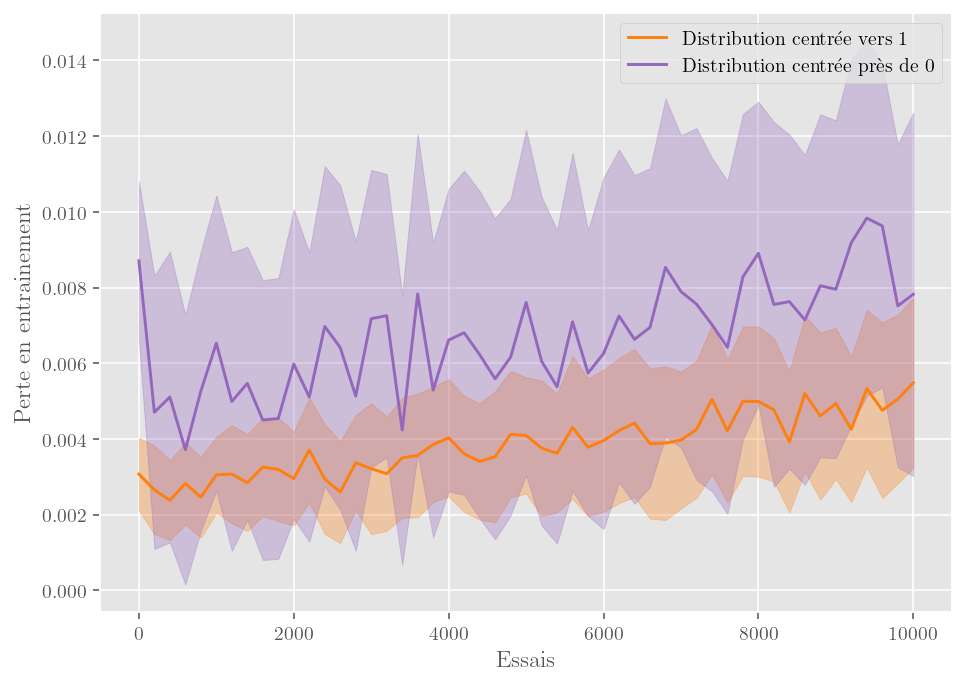

In [85]:
# Plot ratio found pat
metric = "losses"
for i, exp in enumerate(experiments):
    means = np.nanmean(metrics_dict[exp][metric], axis=0)[:(upper_lim // interval)]
    stds = np.nanstd(metrics_dict[exp][metric], axis=0)[:(upper_lim// interval)]
    x = np.arange(len(means)) * interval

    plt.plot(x, means, color=colors[i], label=labels[i])
    plt.fill_between(x, means - stds, means + stds, color=colors[i], alpha=0.3)
plt.xlabel('Essais')
plt.ylabel("Perte en entrainement")
plt.legend()
plt.tight_layout()

plt.savefig(f'images/polypharmacy/perf/{prefix}_{metric}_{labels_fn}')


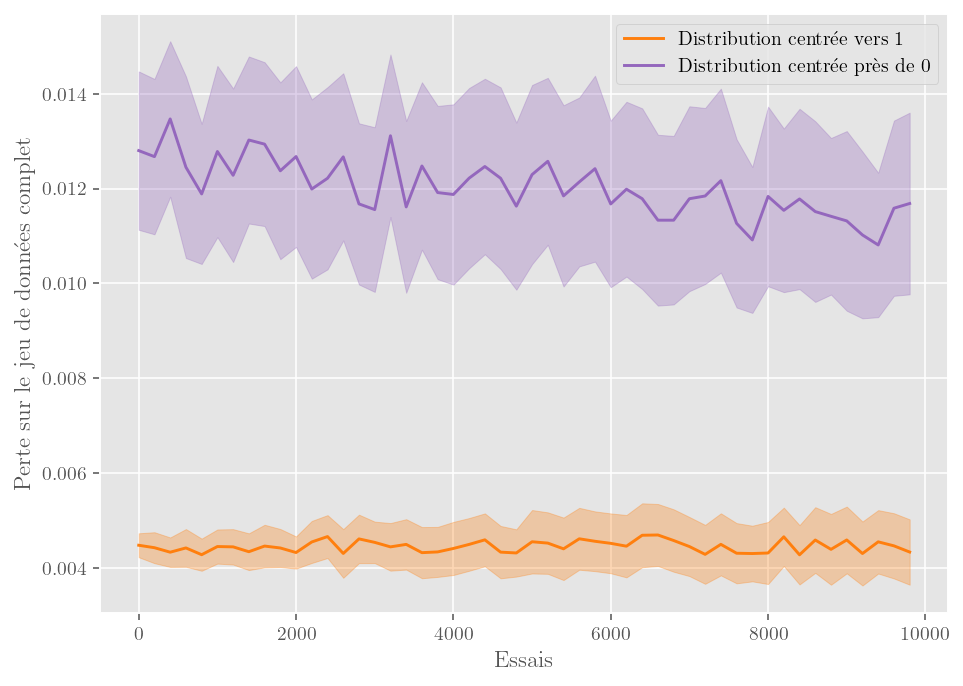

In [86]:
# Plot ratio found pat
metric = "dataset_losses"

for i, exp in enumerate(experiments):
    means = np.nanmean(metrics_dict[exp][metric], axis=0)[:(upper_lim // interval)]
    stds = np.nanstd(metrics_dict[exp][metric], axis=0)[:(upper_lim// interval)]
    x = np.arange(len(means)) * interval

    plt.plot(x, means, color=colors[i], label=labels[i])
    plt.fill_between(x, means - stds, means + stds, color=colors[i], alpha=0.3)
plt.xlabel('Essais')
plt.ylabel("Perte sur le jeu de données complet")
plt.legend()
plt.tight_layout()
plt.savefig(f'images/polypharmacy/perf/{prefix}_{metric}_{labels_fn}')


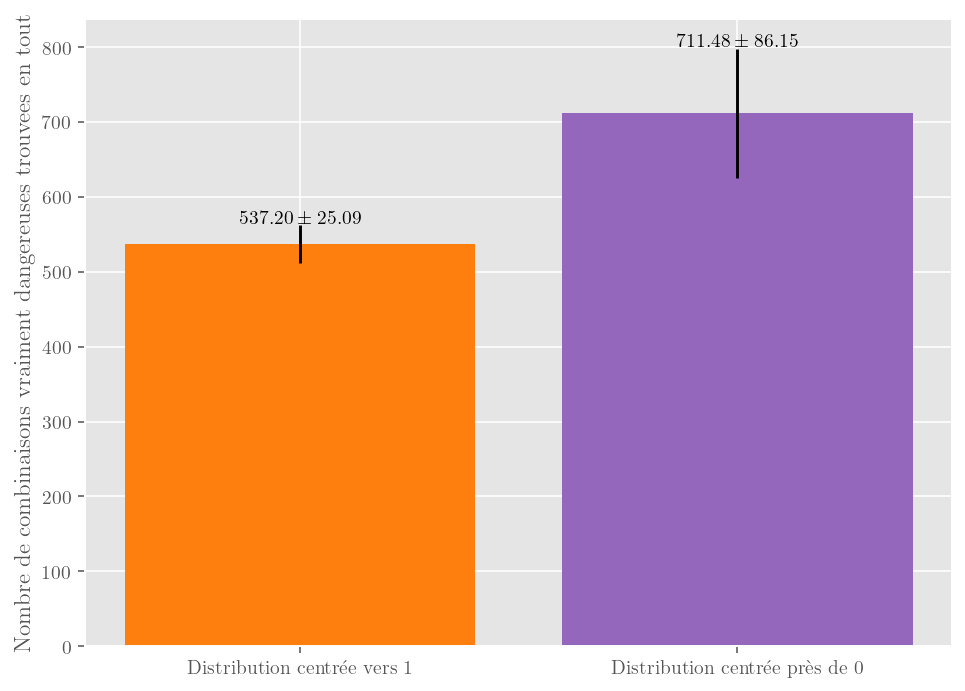

In [87]:
# Plot ratio found pat
metric = "n_inter_alls"
n_inter_means = []
n_inter_stds = []

for i, exp in enumerate(experiments):
    n_inters = []
    for j in range(n_runs):
        n_inters.append(metrics_dict[exp][metric][j][-1])

    n_inters = np.array(n_inters)
    mean = np.nanmean(n_inters)
    n_inter_means.append(mean)
    n_inter_std = np.nanstd(n_inters)
    n_inter_stds.append(n_inter_std)

fig, ax = plt.subplots()
p1 = ax.bar(list(range(len(labels))), n_inter_means, yerr=n_inter_stds, color=colors)

# plt.xlabel('Graine aleatoire')
ax.set_xticks(list(range(len(labels))), labels=labels)
ax.set_ylabel("Nombre de combinaisons vraiment dangereuses trouvees en tout")
ax.bar_label(p1, labels=[f"${m:.2f} \pm {s:.2f}$" for m, s in zip(n_inter_means, n_inter_stds)])
plt.tight_layout()
plt.savefig(f'images/polypharmacy/perf/{prefix}_{metric}_{labels_fn}')


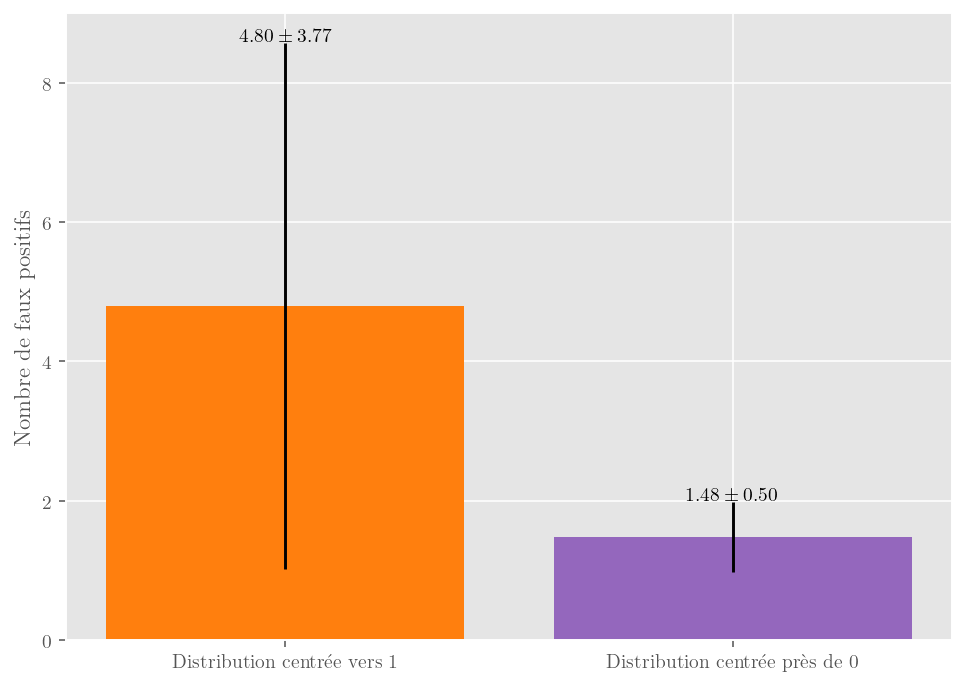

In [88]:
# Plot ratio found pat
metric = "all_flagged_risks"
thresh = 1.1
means = []
stds = []
for i, exp in enumerate(experiments):
    n_flagged_below_thresh = []
    for j in range(n_runs):
        # n_total_flagged = sum(metrics_dict[exp][metric][j])
        if metrics_dict[exp][metric][j].nelement() == 0:
            continue
        n = sum(metrics_dict[exp][metric][j] < thresh)
        n_flagged_below_thresh.append(n.item())

    seeds = np.arange(len(n_flagged_below_thresh))
    n_flagged_below_thresh = np.array(n_flagged_below_thresh)
    mean = np.nanmean(n_flagged_below_thresh)
    std = np.nanstd(n_flagged_below_thresh)

    means.append(mean)
    stds.append(std)


fig, ax = plt.subplots()
p1 = ax.bar(list(range(len(labels))), means, yerr=stds, color=colors)
# plt.xlabel('Graine aleatoire')
ax.set_xticks(list(range(len(labels))), labels=labels)
ax.set_ylabel("Nombre de faux positifs")
ax.bar_label(p1, labels=[f"${m:.2f} \pm {s:.2f}$" for m, s in zip(means, stds)])

plt.tight_layout()
plt.savefig(f"images/polypharmacy/perf/{prefix}_{metric}_{labels_fn}_fauxpos")


In [89]:
def color_and_label_violinplot(violin, color, label):
    for pc in violin['bodies']:
        pc.set_color(color)

    violin["cbars"].set_color(color)
    # violin["cmeans"].set_color(color)
    violin["cmins"].set_color(color)
    violin["cmaxes"].set_color(color)
    
    fig_labels.append((mpatches.Patch(color=color), label))


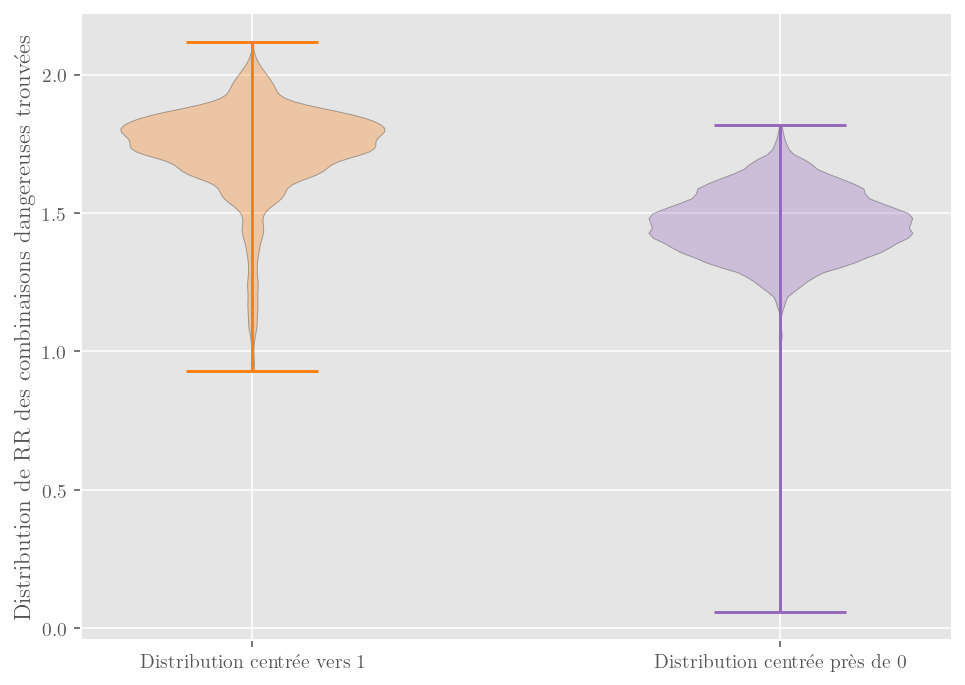

In [90]:
# Plot ratio found pat
fig_labels = []
metric = "all_flagged_risks"
all_flagged_risks_indiv = []
for i, exp in enumerate(experiments):
    all_flagged_risks_this_exp = []
    for j in range(n_runs):
        all_flagged_risks_this_exp.extend(metrics_dict[exp][metric][j].flatten().tolist())
    all_flagged_risks_indiv.append(all_flagged_risks_this_exp)

violin_plot = plt.violinplot(all_flagged_risks_indiv)
for i, pc in enumerate(violin_plot["bodies"]):
    pc.set_facecolor(colors[i])
    pc.set_edgecolor('black')
violin_plot["cbars"].set_color(colors)
violin_plot["cmins"].set_color(colors)
violin_plot["cmaxes"].set_color(colors)

plt.xticks(list(range(1, len(labels) + 1)), labels)
plt.ylabel("Distribution de RR des combinaisons dangereuses trouvées")
plt.tight_layout()
plt.savefig(f"images/polypharmacy/perf/{prefix}_{metric}_where_flagged_{labels_fn}")


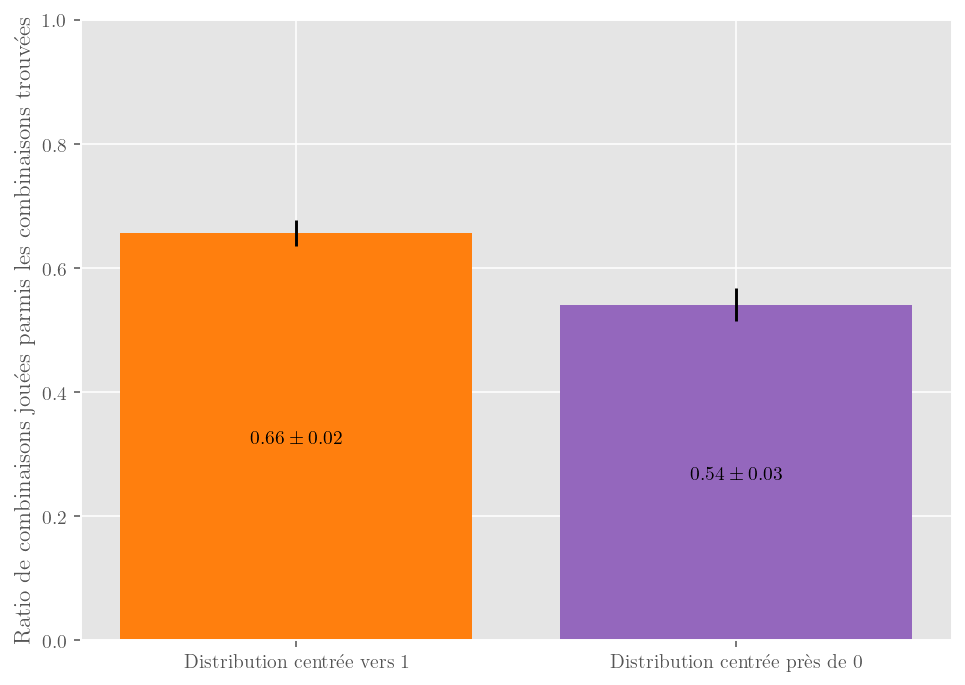

In [91]:
# Plot ratio found pat
metric = "all_flagged_combis_idx"
means, stds = [], []
for i, exp in enumerate(experiments):
    n_inter, percent_of_flagged_in_train = [], []
    combis, risks, pat_vecs, n_obs, n_dim = load_dataset(
        datasets[i], path_to_dataset="../datasets"
    )
    for j in range(n_runs):
        all_flagged_combis_idx = list(metrics_dict[exp][metric][j])
        all_flagged_combis = combis[all_flagged_combis_idx]
        training_set = metrics_dict[exp]["agents"][j].train_dataset.features
        inter, percent = compute_n_inter(all_flagged_combis, training_set)
        n_inter.append(inter)
        percent_of_flagged_in_train.append(percent)

    means.append(np.nanmean(percent_of_flagged_in_train))
    stds.append(np.nanstd(percent_of_flagged_in_train))

fig, ax = plt.subplots()
p1 = ax.bar(list(range(len(labels))), means, yerr=stds, color=colors)
ax.set_xticks(list(range(len(labels))), labels=labels)
ax.set_ylabel("Ratio de combinaisons jouées parmis les combinaisons trouvées")
ax.set_ylim(0, 1)
ax.bar_label(p1, label_type="center", labels=[f"${m:.2f} \pm {s:.2f}$" for m, s in zip(means, stds)])

plt.tight_layout()
plt.savefig(
    f"images/polypharmacy/perf/{prefix}_can_we_use_replay_buffer_to_flag_{labels_fn}"
)
